# Generative Adversarial Networks for Beginners
## Build a neural network that learns to generate handwritten digits.
### By [Jon Bruner](https://github.com/jonbruner) and [Adit Deshpande](https://github.com/adeshpande3)

This notebook accompanies [the O'Reilly interactive tutorial on generative adversarial networks](https://www.oreilly.com/learning/generative-adversarial-networks-for-beginners). See the original tutorial to run this code in a pre-built environment on O'Reilly's servers with cell-by-cell guidance, or run this notebook on your own machine.

Also, see [gan-script.py](gan-script.py) in this repository for a straight Python implementation of this code.

### Prerequisites

You'll need [TensorFlow](https://www.tensorflow.org/install/), [NumPy](https://docs.scipy.org/doc/numpy/user/install.html), [matplotlib](https://matplotlib.org/) and [Jupyter](https://jupyter.readthedocs.io/en/latest/install.html) in order to run this notebook on your machine. See [the readme](https://github.com/jonbruner/generative-adversarial-networks) for advice on installing these packages.

## Introduction

According to Yann LeCun, “adversarial training is the coolest thing since sliced bread.” Sliced bread certainly never created this much excitement within the deep learning community. Generative adversarial networks—or GANs, for short—have dramatically sharpened the possibility of AI-generated content, and have drawn active research efforts since they were [first described by Ian Goodfellow et al. in 2014](https://arxiv.org/abs/1406.2661).

GANs are neural networks that learn to create synthetic data similar to some known input data. For instance, researchers have generated convincing images from [photographs of everything from bedrooms to album covers](https://github.com/Newmu/dcgan_code), and they display a remarkable ability to reflect [higher-order semantic logic](https://github.com/Newmu/dcgan_code).

Those examples are fairly complex, but it's easy to build a GAN that generates very simple images. In this tutorial, we'll build a GAN that analyzes lots of images of handwritten digits and gradually learns to generate new images from scratch—*essentially, we'll be teaching a neural network how to write*.

<img src="notebook-images/gan-animation.gif" />
_Sample images from the generative adversarial network that we'll build in this tutorial. During training, it gradually refines its ability to generate digits._

## GAN architecture

Generative adversarial networks consist of two models: a generative model and a discriminative model.

![caption](notebook-images/GAN_Overall.png)

The discriminator model is a classifier that determines whether a given image looks like a real image from the dataset or like an artificially created image. This is basically a binary classifier that will take the form of a normal convolutional neural network (CNN).

The generator model takes random input values and transforms them into images through a deconvolutional neural network.

Over the course of many training iterations, the weights and biases in the discriminator and the generator are trained through backpropagation. The discriminator learns to tell "real" images of handwritten digits apart from "fake" images created by the generator. At the same time, the generator uses feedback from the discriminator to learn how to produce convincing images that the discriminator can't distinguish from real images.

## Getting started

We’re going to create a GAN that will generate handwritten digits that can fool even the best classifiers (and humans too, of course). We'll use [TensorFlow](https://www.tensorflow.org/), a deep learning library open-sourced by Google that makes it easy to train neural networks on GPUs.

This tutorial expects that you're already at least a little bit familiar with TensorFlow. If you're not, we recommend reading "[Hello, TensorFlow!](https://www.oreilly.com/learning/hello-tensorflow)" or watching the "[Hello, Tensorflow!](https://www.safaribooksonline.com/oriole/hello-tensorflow-oriole)" interactive tutorial on Safari before proceeding.

## Loading MNIST data

We need a set of real handwritten digits to give the discriminator a starting point in distinguishing between real and fake images. We'll use [MNIST](http://yann.lecun.com/exdb/mnist/), a benchmark dataset in deep learning. It consists of 70,000 images of handwritten digits compiled by the U.S. National Institute of Standards and Technology from Census Bureau employees and high school students.

Let's start by importing TensorFlow along with a couple of other helpful libraries. We'll also import our MNIST images using a TensorFlow convenience function called `read_data_sets`.

In [1]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

W0529 13:01:47.119661 4572030400 deprecation.py:323] From <ipython-input-1-c8b10386149a>:8: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0529 13:01:47.120571 4572030400 deprecation.py:323] From /anaconda2/envs/py37/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0529 13:01:47.121497 4572030400 deprecation.py:323] From /anaconda2/envs/py37/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instru

Extracting MNIST_data/train-images-idx3-ubyte.gz


W0529 13:01:47.341187 4572030400 deprecation.py:323] From /anaconda2/envs/py37/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0529 13:01:47.384470 4572030400 deprecation.py:323] From /anaconda2/envs/py37/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


The MNIST variable we created above contains both the images and their labels, divided into a training set called `train` and a validation set called `validation`. (We won't need to worry about the labels in this tutorial.) We can retrieve batches of images by calling `next_batch` on `mnist`. Let's load one image and look at it.

The images are initially formatted as a single row of 784 pixels. We can reshape them into 28 x 28-pixel images and view them using pyplot.

(1, 784)


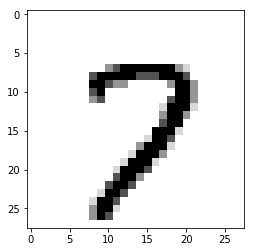

In [2]:
sample_image = mnist.train.next_batch(1)[0]
print(sample_image.shape)

sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image, cmap='Greys')

If you run the cell above again, you'll see a different image from the MNIST training set.

## Discriminator network

Our discriminator is a convolutional neural network that takes in an image of size 28 x 28 x 1 as input and returns a single scalar number that describes whether or not the input image is "real" or "fake"—that is, whether it's drawn from the set of MNIST images or generated by the generator.

![caption](notebook-images/GAN_Discriminator.png)

The structure of our discriminator network is based closely on [TensorFlow's sample CNN classifier model](https://www.tensorflow.org/get_started/mnist/pros). It features two convolutional layers that find 5x5-pixel features, and two "fully connected" layers that multiply weights by every pixel in the image.

To set up each layer, we start by creating weight and bias variables through [`tf.get_variable`](https://www.tensorflow.org/api_docs/python/tf/get_variable). Weights are initialized from a [truncated normal](https://www.tensorflow.org/api_docs/python/tf/truncated_normal) distribution, and biases are initialized at zero.

[`tf.nn.conv2d()`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d) is TensorFlow's standard convolution function. It takes 4 arguments. The first is the input volume (our `28 x 28 x 1` images in this case). The next argument is the filter/weight matrix. Finally, you can also change the stride and padding of the convolution. Those two values affect the dimensions of the output volume.

If you're already comfortable with CNNs, you'll recognize this as a simple binary classifier—nothing fancy. 

In [3]:
def discriminator(images, reuse_variables=None):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse_variables) as scope:
        # First convolutional and pool layers
        # This finds 32 different 5 x 5 pixel features
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
        d1 = d1 + d_b1
        d1 = tf.nn.relu(d1)
        d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # Second convolutional and pool layers
        # This finds 64 different 5 x 5 pixel features
        d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
        d2 = d2 + d_b2
        d2 = tf.nn.relu(d2)
        d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # First fully connected layer
        d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
        d3 = tf.matmul(d3, d_w3)
        d3 = d3 + d_b3
        d3 = tf.nn.relu(d3)

        # Second fully connected layer
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
        d4 = tf.matmul(d3, d_w4) + d_b4

        # d4 contains unscaled values
        return d4

## Generator network

![caption](notebook-images/GAN_Generator.png)

Now that we have our discriminator defined, let’s take a look at the generator model. We'll base the overall structure of our model on a simple generator published by [Tim O'Shea](https://github.com/osh/KerasGAN).

You can think of the generator as a kind of reverse convolutional neural network. A typical CNN like our discriminator network transforms a 2- or 3-dimensional matrix of pixel values into a single probability. A generator, however, takes a `d`-dimensional vector of noise and upsamples it to become a 28 x 28 image. ReLU and batch normalization are used to stabilize the outputs of each layer.

In our generator network, we use three convolutional layers along with interpolation until a `28 x 28` pixel image is formed. (Actually, as you'll see below, we've taken care to form `28 x 28 x 1` images; many TensorFlow tools for dealing with images anticipate that the images will have some number of _channels_—usually 1 for greyscale images or 3 for RGB color images.)

At the output layer we add a [`tf.sigmoid()`](https://www.tensorflow.org/api_docs/python/tf/sigmoid) activation function; this squeezes pixels that would appear grey toward either black or white, resulting in a crisper image.

In [4]:
def generator(z, batch_size, z_dim):
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='g_b1')
    g1 = tf.nn.relu(g1)

    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='g_b2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='g_b3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)
    
    # Dimensions of g4: batch_size x 28 x 28 x 1
    return g4

## Generating a sample image

Now we’ve defined both the generator and discriminator functions. Let’s see what a sample output from an untrained generator looks like.

We need to open a TensorFlow session and create a placeholder for the input to our generator. The shape of the placeholder will be `None, z_dimensions`. The `None` keyword means that the value can be determined at session runtime. We normally have `None` as our first dimension so that we can have variable batch sizes. (With a batch size of 50, the input to the generator would be 50 x 100). With the `None` keywoard, we don't have to specify `batch_size` until later. 

In [5]:
z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

Now, we create a variable (`generated_image_output`) that holds the output of the generator, and we'll also initialize the random noise vector that we're going to use as input. The [`np.random.normal()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html) function has three arguments. The first and second define the mean and standard deviation for the normal distribution (0 and 1 in our case), and the third defines the the shape of the vector (`1 x 100`).

In [6]:
generated_image_output = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(0, 1, [1, z_dimensions])

Next, we initialize all the variables, feed our `z_batch` into the placeholder, and run the session.

The [`sess.run()`](https://www.tensorflow.org/api_docs/python/tf/Session#run) function has two arguments. The first is called the "fetches" argument; it defines the value you're interested in computing. In our case, we want to see what the output of the generator is. If you look back at the last code snippet, you'll see that the output of the generator function is stored in `generated_image_output`, so we'll use `generated_image_output` for our first argument.

The second argument takes a dictionary of inputs that are substituted into the graph when it runs. This is where we feed in our placeholders. In our example, we need to feed our `z_batch` variable into the `z_placeholder` that we defined earlier. As before, we'll view the image by reshaping it to `28 x 28` pixels and show it with PyPlot.

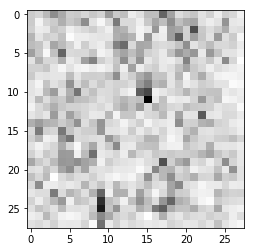

In [7]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output,
                                feed_dict={z_placeholder: z_batch})
    generated_image = generated_image.reshape([28, 28])
    plt.imshow(generated_image, cmap='Greys')

That looks like noise, right? Now we need to train the weights and biases in the generator network to convert random numbers into recognizable digits. Let's look at loss functions and optimization!

## Training a GAN

One of the trickiest parts about building and tuning GANs is that they have two loss functions: one that encourages the generator to create better images, and the other that encourages the discriminator to distinguish generated images from real images.

We train both the generator and the discriminator simultaneously. As the discriminator gets better at distinguishing real images from generated images, the generator is able to better tune its weights and biases to generate convincing images.

Here are the inputs and outputs for our networks.

In [8]:
tf.reset_default_graph()
batch_size = 50

z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
# z_placeholder is for feeding input noise to the generator

x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_placeholder') 
# x_placeholder is for feeding input images to the discriminator

Gz = generator(z_placeholder, batch_size, z_dimensions) 
# Gz holds the generated images

Dx = discriminator(x_placeholder) 
# Dx will hold discriminator prediction probabilities
# for the real MNIST images

Dg = discriminator(Gz, reuse_variables=True)
# Dg will hold discriminator prediction probabilities for generated images

So, let’s first think about what we want out of our networks. The discriminator's goal is to correctly label real MNIST images as real (return a higher output) and generated images as fake (return a lower output). We'll calculate two losses for the discriminator: one loss that compares `Dx` and 1 for real images from the MNIST set, as well as a loss that compares `Dg` and 0 for images from the generator. We'll do this with TensorFlow's [`tf.nn.sigmoid_cross_entropy_with_logits()`](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) function, which calculates the cross-entropy losses between `Dx` and 1 and between `Dg` and 0.

`sigmoid_cross_entropy_with_logits` operates on unscaled values rather than probability values from 0 to 1. Take a look at the last line of our discriminator: there's no softmax or sigmoid layer at the end. GANs can fail if their discriminators "saturate," or become confident enough to return exactly 0 when they're given a generated image; that leaves the discriminator without a useful gradient to descend.

The [`tf.reduce_mean()`](https://www.tensorflow.org/api_docs/python/tf/reduce_mean) function takes the mean value of all of the components in the matrix returned by the cross entropy function. This is a way of reducing the loss to a single scalar value, instead of a vector or matrix.

In [9]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))

Now let's set up the generator's loss function. We want the generator network to create images that will fool the discriminator: the generator wants the discriminator to output a value close to 1 when it's given an image from the generator. Therefore, we want to compute the loss between `Dg` and 1.

In [10]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg)))  

Now that we have our loss functions, we need to define our optimizers. The optimizer for the generator network needs to only update the generator’s weights, not those of the discriminator. Likewise, when we train the discriminator, we want to hold the generator's weights fixed.

In order to make this distinction, we need to create two lists of variables, one with the discriminator’s weights and biases and another with the generator’s weights and biases. This is where naming all of your TensorFlow variables with a thoughtful scheme can come in handy.

In [11]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['d_w1:0', 'd_b1:0', 'd_w2:0', 'd_b2:0', 'd_w3:0', 'd_b3:0', 'd_w4:0', 'd_b4:0']
['g_w1:0', 'g_b1:0', 'g_b1/beta:0', 'g_w2:0', 'g_b2:0', 'g_b2/beta:0', 'g_w3:0', 'g_b3:0', 'g_b3/beta:0', 'g_w4:0', 'g_b4:0']


Next, we specify our two optimizers. [Adam](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer) is usually the optimization algorithm of choice for GANs; it utilizes adaptive learning rates and momentum. We call Adam's minimize function and also specify the variables that we want it to update—the generator's weights and biases when we train the generator, and the discriminator's weights and biases when we train the discriminator.

We're setting up two different training operations for the discriminator here: one that trains the discriminator on real images and one that trains the discrmnator on fake images. It's sometimes useful to use different learning rates for these two training operations, or to use them separately to [regulate learning in other ways](https://github.com/jonbruner/ezgan).

In [12]:
# Train the discriminator
d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)

# Train the generator
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

It can be tricky to get GANs to converge, and moreover they often need to train for a very long time. [TensorBoard](https://www.tensorflow.org/how_tos/summaries_and_tensorboard/) is useful for tracking the training process; it can graph scalar properties like losses, display sample images during training, and illustrate the topology of the neural networks.

If you run this script on your own machine, include the cell below. Then, in a terminal window from the directory that this notebook lives in, run

```
tensorboard --logdir=tensorboard/
```

and open TensorBoard by visiting [`http://localhost:6006`](http://localhost:6006) in your web browser.

In [13]:
# From this point forward, reuse variables
tf.get_variable_scope().reuse_variables()

tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions)
tf.summary.image('Generated_images', images_for_tensorboard, 5)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

And now we iterate. We begin by briefly giving the discriminator some initial training; this helps it develop a gradient that's useful to the generator.

Then we move on to the main training loop. When we train the generator, we’ll feed a random `z` vector into the generator and pass its output to the discriminator (this is the `Dg` variable we specified earlier). The generator’s weights and biases will be updated in order to produce images that the discriminator is more likely to classify as real.

To train the discriminator, we’ll feed it a batch of images from the MNIST set to serve as the positive examples, and then train the discriminator again on generated images, using them as negative examples. Remember that as the generator improves its output, the discriminator continues to learn to classify the improved generator images as fake.

Because it takes a long time to train a GAN, **we recommend not running this code block if you're going through this tutorial for the first time**. Instead, follow along but then run the following code block, which loads a pre-trained model for us to continue the tutorial.

**If you want to run this code yourself, prepare to wait: it takes about three hours on a fast GPU, but could take ten times that long on a desktop CPU.**

dLossReal: 0.6915876 dLossFake: 0.71440697
dLossReal: 0.022644114 dLossFake: 0.042798366
dLossReal: 0.00026373463 dLossFake: 0.00076289056
Iteration: 0 at 2019-05-29 13:03:23.040384


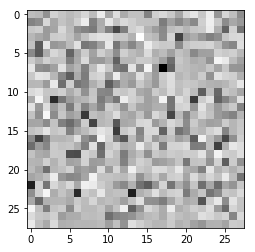

Estimate: [[-7.864964]]
Iteration: 100 at 2019-05-29 13:04:03.775792


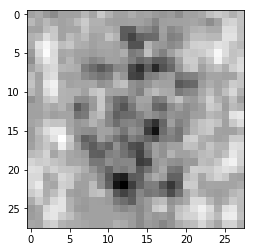

Estimate: [[-8.070506]]
Iteration: 200 at 2019-05-29 13:04:42.520321


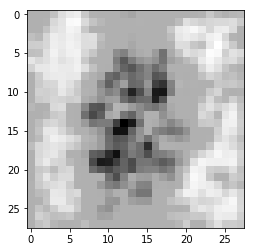

Estimate: [[-7.235022]]
Iteration: 300 at 2019-05-29 13:05:21.292499


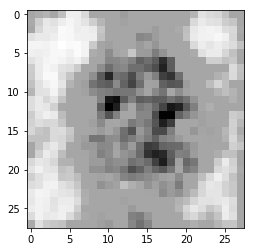

Estimate: [[-8.355175]]
Iteration: 400 at 2019-05-29 13:06:00.485983


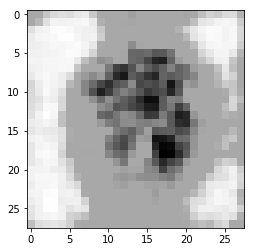

Estimate: [[-8.308779]]
Iteration: 500 at 2019-05-29 13:06:40.074338


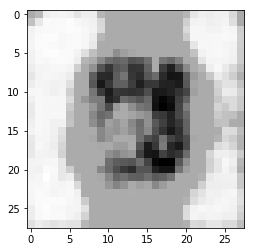

Estimate: [[-8.31781]]
Iteration: 600 at 2019-05-29 13:07:18.529462


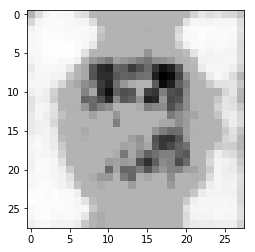

Estimate: [[-11.784203]]
Iteration: 700 at 2019-05-29 13:07:56.968144


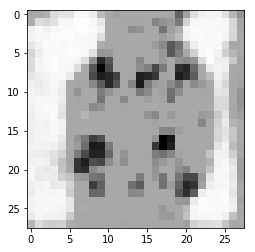

Estimate: [[-7.730914]]
Iteration: 800 at 2019-05-29 13:08:36.884556


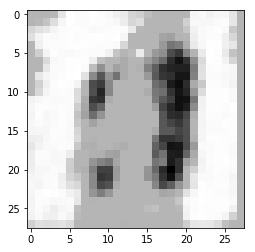

Estimate: [[-6.623477]]
Iteration: 900 at 2019-05-29 13:09:16.883120


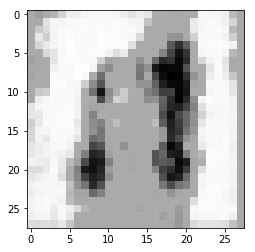

Estimate: [[-6.2522345]]
Iteration: 1000 at 2019-05-29 13:09:56.072265


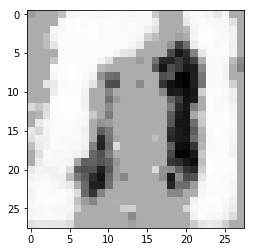

Estimate: [[-5.7161536]]
Iteration: 1100 at 2019-05-29 13:10:35.397071


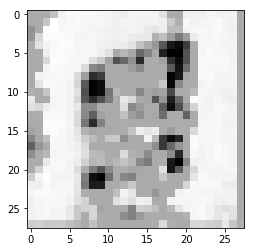

Estimate: [[-18.592793]]
Iteration: 1200 at 2019-05-29 13:11:14.397731


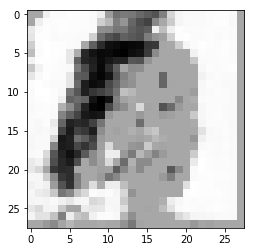

Estimate: [[-7.1209555]]
Iteration: 1300 at 2019-05-29 13:11:53.465556


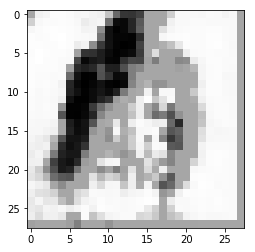

Estimate: [[-8.647848]]
Iteration: 1400 at 2019-05-29 13:12:32.699710


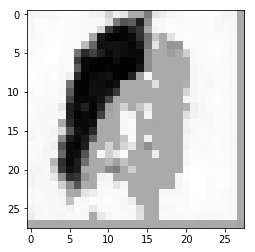

Estimate: [[-7.1162653]]
Iteration: 1500 at 2019-05-29 13:13:11.870606


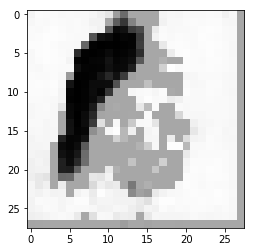

Estimate: [[-5.940831]]
Iteration: 1600 at 2019-05-29 13:13:51.018334


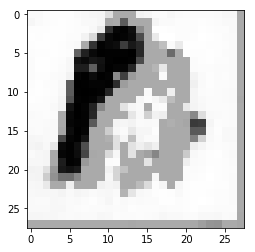

Estimate: [[-6.7330728]]
Iteration: 1700 at 2019-05-29 13:14:30.197605


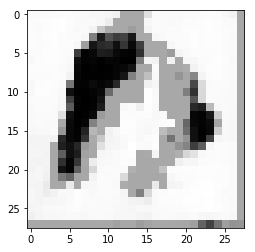

Estimate: [[-6.065393]]
Iteration: 1800 at 2019-05-29 13:15:09.633549


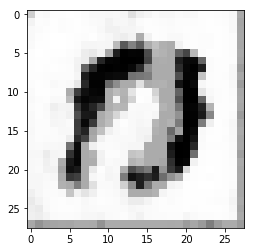

Estimate: [[-7.304662]]
Iteration: 1900 at 2019-05-29 13:15:48.922739


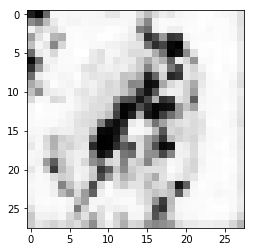

Estimate: [[-20.935339]]
Iteration: 2000 at 2019-05-29 13:16:28.183531


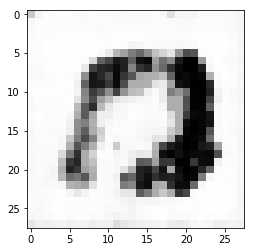

Estimate: [[-35.507317]]
Iteration: 2100 at 2019-05-29 13:17:07.566522


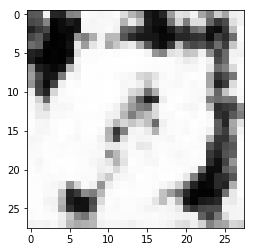

Estimate: [[-16.522203]]
Iteration: 2200 at 2019-05-29 13:17:46.683534


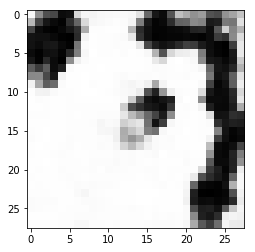

Estimate: [[-14.667503]]
Iteration: 2300 at 2019-05-29 13:18:25.876269


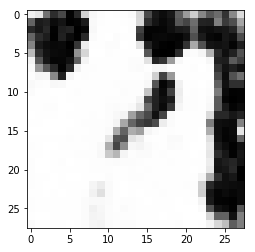

Estimate: [[-11.375481]]
Iteration: 2400 at 2019-05-29 13:19:05.320441


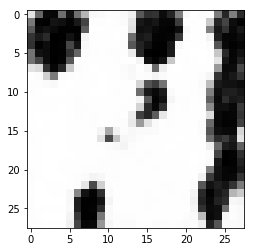

Estimate: [[-12.961791]]
Iteration: 2500 at 2019-05-29 13:19:44.688911


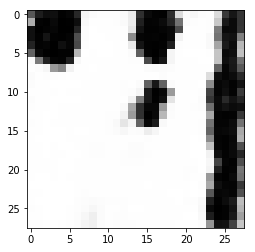

Estimate: [[-9.331327]]
Iteration: 2600 at 2019-05-29 13:33:09.788866


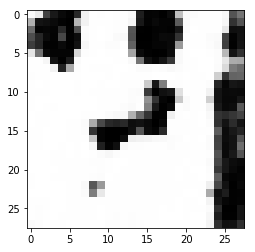

Estimate: [[-9.268428]]
Iteration: 2700 at 2019-05-29 13:33:46.583804


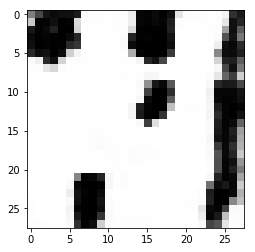

Estimate: [[-7.5985584]]
Iteration: 2800 at 2019-05-29 13:34:22.119099


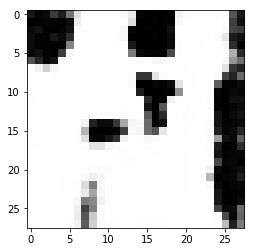

Estimate: [[-10.34504]]
Iteration: 2900 at 2019-05-29 13:35:00.352582


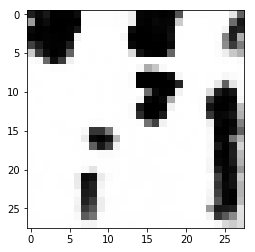

Estimate: [[-10.728651]]
Iteration: 3000 at 2019-05-29 13:35:38.092020


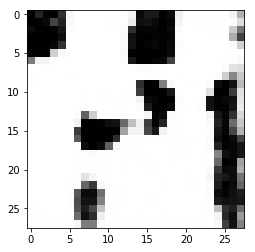

Estimate: [[-7.4783597]]
Iteration: 3100 at 2019-05-29 13:36:18.160359


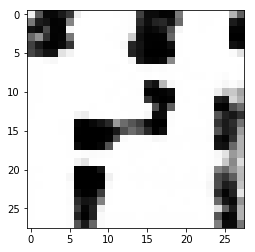

Estimate: [[-8.735197]]
Iteration: 3200 at 2019-05-29 13:36:57.690679


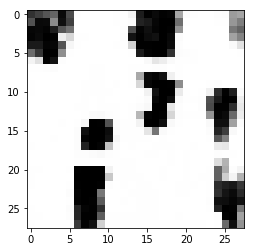

Estimate: [[-9.568088]]
Iteration: 3300 at 2019-05-29 13:37:38.498368


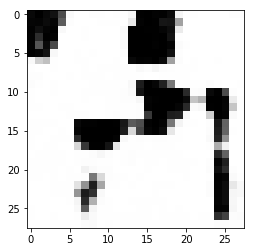

Estimate: [[-7.1302648]]
Iteration: 3400 at 2019-05-29 13:38:18.316997


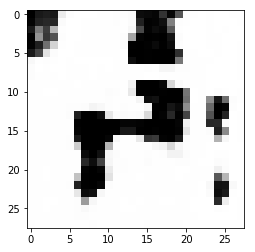

Estimate: [[-9.023113]]
Iteration: 3500 at 2019-05-29 13:38:59.378352


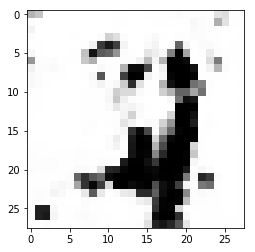

Estimate: [[-46.227818]]
Iteration: 3600 at 2019-05-29 13:39:38.758724


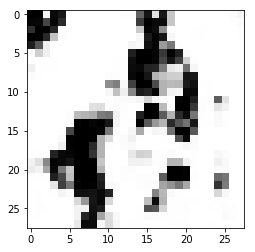

Estimate: [[-128.25229]]
Iteration: 3700 at 2019-05-29 13:40:18.231844


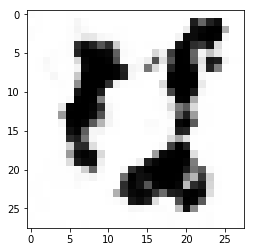

Estimate: [[-148.2736]]
Iteration: 3800 at 2019-05-29 13:40:58.477750


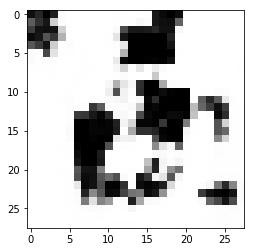

Estimate: [[-101.21157]]
Iteration: 3900 at 2019-05-29 13:41:39.884494


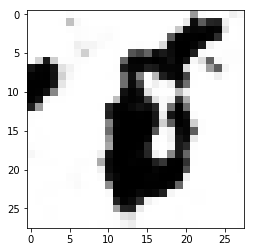

Estimate: [[-2.1925242]]
Iteration: 4000 at 2019-05-29 13:42:19.909634


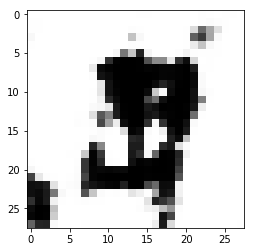

Estimate: [[-121.929665]]
Iteration: 4100 at 2019-05-29 13:43:00.283036


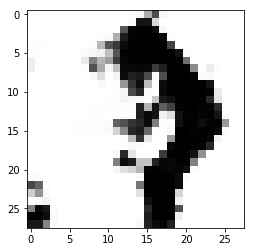

Estimate: [[-15.272562]]
Iteration: 4200 at 2019-05-29 13:43:36.903881


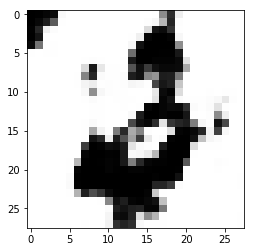

Estimate: [[-57.90106]]
Iteration: 4300 at 2019-05-29 13:44:13.732192


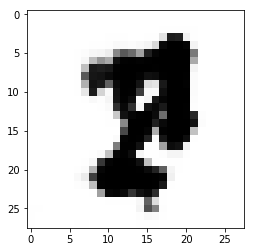

Estimate: [[-33.04224]]
Iteration: 4400 at 2019-05-29 13:44:50.994224


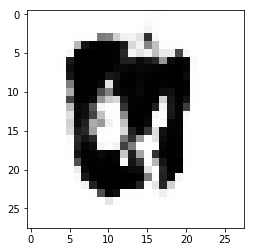

Estimate: [[-11.240371]]
Iteration: 4500 at 2019-05-29 13:45:28.810591


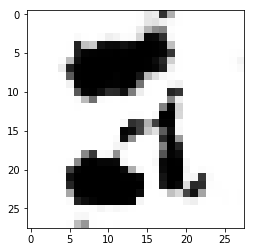

Estimate: [[26.226263]]
Iteration: 4600 at 2019-05-29 13:46:05.542870


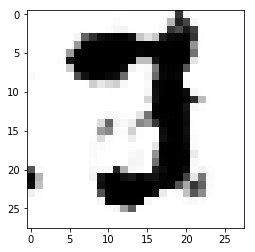

Estimate: [[-51.58553]]
Iteration: 4700 at 2019-05-29 13:46:42.355356


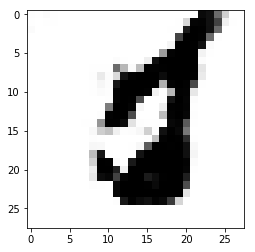

Estimate: [[-58.067005]]
Iteration: 4800 at 2019-05-29 13:47:19.086622


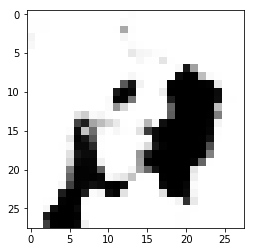

Estimate: [[-45.731617]]
Iteration: 4900 at 2019-05-29 13:47:55.796551


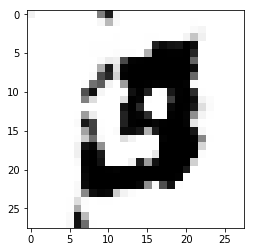

Estimate: [[-56.601295]]
Iteration: 5000 at 2019-05-29 13:48:32.571991


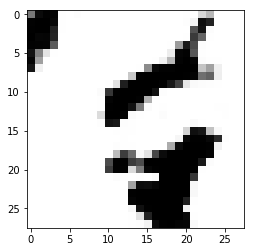

Estimate: [[14.701212]]
Iteration: 5100 at 2019-05-29 13:49:09.347097


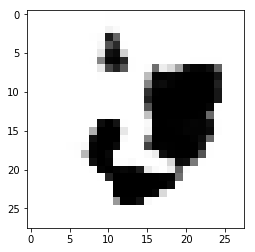

Estimate: [[-18.277452]]
Iteration: 5200 at 2019-05-29 13:49:46.381080


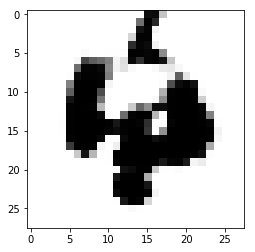

Estimate: [[2.1203308]]
Iteration: 5300 at 2019-05-29 13:50:25.034957


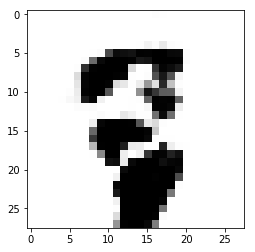

Estimate: [[-43.76418]]
Iteration: 5400 at 2019-05-29 13:51:04.592380


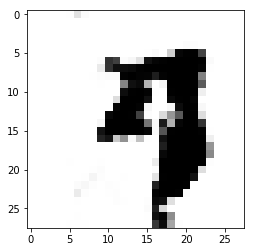

Estimate: [[-47.746613]]
Iteration: 5500 at 2019-05-29 13:51:42.349163


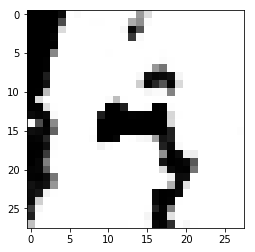

Estimate: [[-62.15741]]
Iteration: 5600 at 2019-05-29 13:52:20.214227


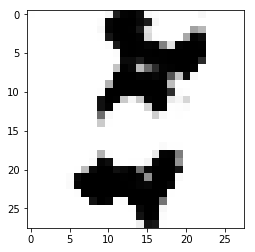

Estimate: [[-2.3289263]]
Iteration: 5700 at 2019-05-29 13:52:58.144290


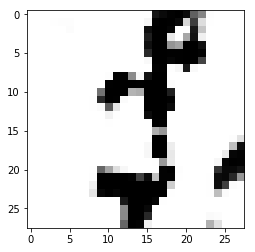

Estimate: [[-28.128141]]
Iteration: 5800 at 2019-05-29 13:53:36.180356


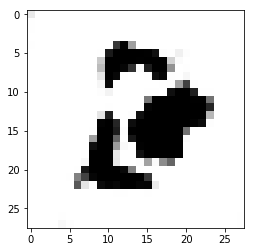

Estimate: [[-0.9484686]]
Iteration: 5900 at 2019-05-29 13:54:14.019354


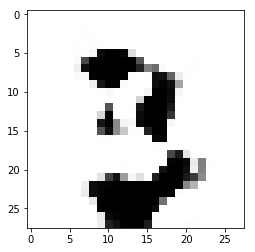

Estimate: [[39.74073]]
Iteration: 6000 at 2019-05-29 13:54:52.597454


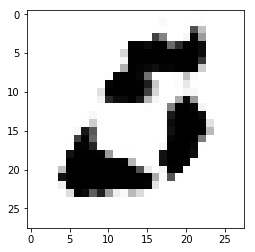

Estimate: [[6.831537]]
Iteration: 6100 at 2019-05-29 13:55:31.091164


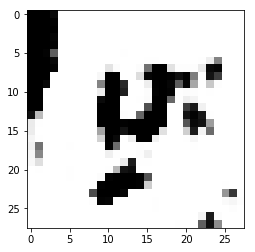

Estimate: [[-45.23717]]
Iteration: 6200 at 2019-05-29 13:56:09.200645


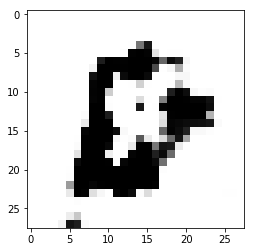

Estimate: [[-8.286613]]
Iteration: 6300 at 2019-05-29 13:56:47.365783


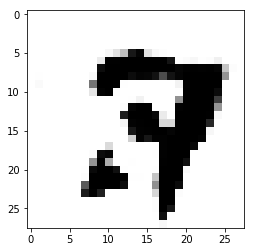

Estimate: [[7.5700784]]
Iteration: 6400 at 2019-05-29 13:57:24.458386


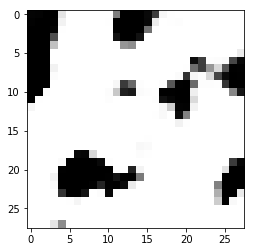

Estimate: [[-63.688038]]
Iteration: 6500 at 2019-05-29 13:58:01.598026


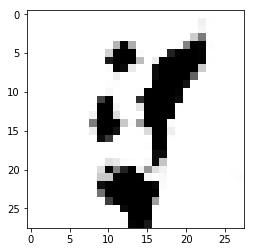

Estimate: [[-18.648937]]
Iteration: 6600 at 2019-05-29 13:58:38.496299


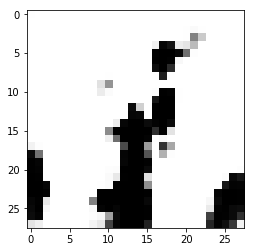

Estimate: [[-23.372847]]
Iteration: 6700 at 2019-05-29 13:59:15.460669


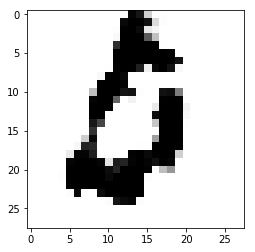

Estimate: [[5.568002]]
Iteration: 6800 at 2019-05-29 13:59:52.908015


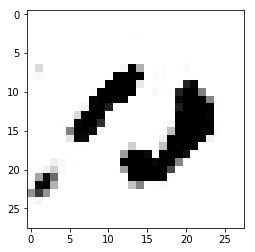

Estimate: [[-8.902101]]
Iteration: 6900 at 2019-05-29 14:00:30.474501


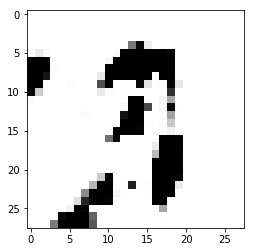

Estimate: [[-1.1792996]]
Iteration: 7000 at 2019-05-29 14:01:11.347366


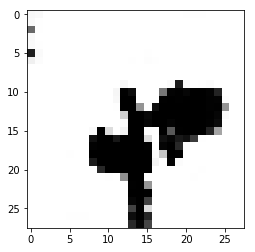

Estimate: [[-9.121389]]
Iteration: 7100 at 2019-05-29 14:01:49.311116


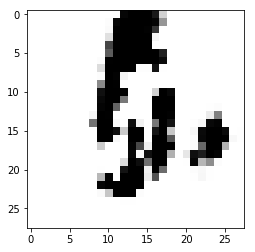

Estimate: [[36.1514]]
Iteration: 7200 at 2019-05-29 14:02:25.458505


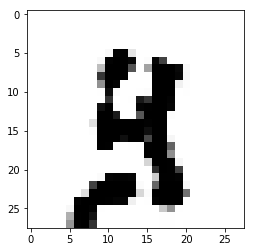

Estimate: [[22.503128]]
Iteration: 7300 at 2019-05-29 14:03:01.722208


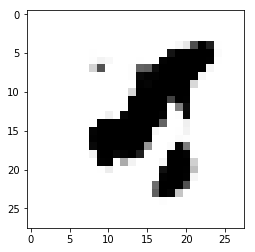

Estimate: [[21.668802]]
Iteration: 7400 at 2019-05-29 14:03:38.592096


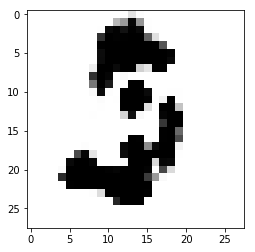

Estimate: [[-8.157137]]
Iteration: 7500 at 2019-05-29 14:04:16.674803


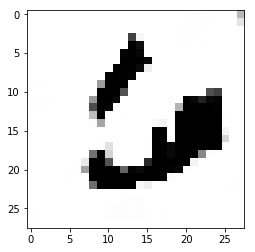

Estimate: [[4.7881]]
Iteration: 7600 at 2019-05-29 14:04:54.729296


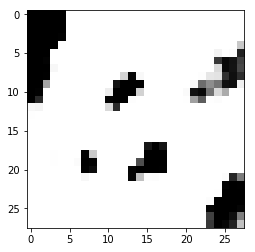

Estimate: [[70.621124]]
Iteration: 7700 at 2019-05-29 14:05:33.680602


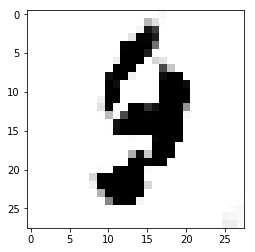

Estimate: [[-3.706581]]
Iteration: 7800 at 2019-05-29 14:06:10.773333


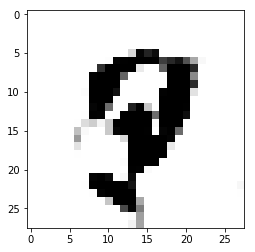

Estimate: [[15.7035055]]
Iteration: 7900 at 2019-05-29 14:06:48.241970


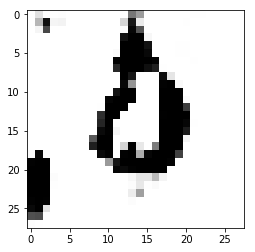

Estimate: [[25.17041]]
Iteration: 8000 at 2019-05-29 14:07:25.788105


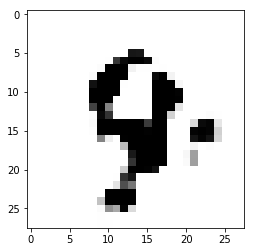

Estimate: [[12.658262]]
Iteration: 8100 at 2019-05-29 14:08:03.051329


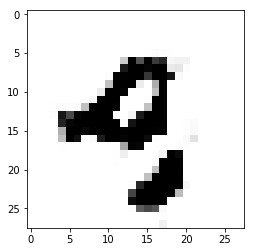

Estimate: [[20.316532]]
Iteration: 8200 at 2019-05-29 14:08:40.233691


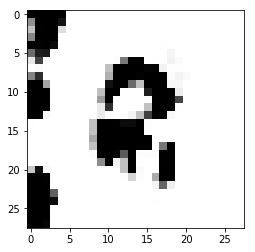

Estimate: [[-57.209126]]
Iteration: 8300 at 2019-05-29 14:09:20.132519


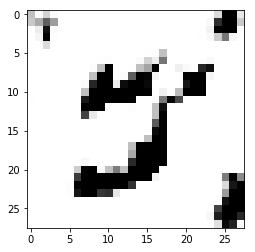

Estimate: [[8.474095]]
Iteration: 8400 at 2019-05-29 14:10:01.212340


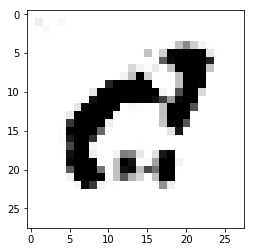

Estimate: [[-28.239576]]
Iteration: 8500 at 2019-05-29 14:10:40.689378


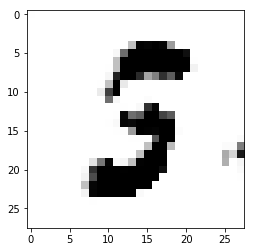

Estimate: [[-22.584652]]
Iteration: 8600 at 2019-05-29 14:11:18.336654


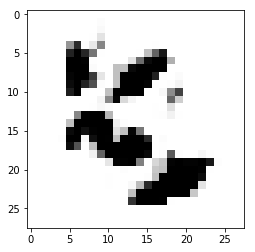

Estimate: [[-1.944387]]
Iteration: 8700 at 2019-05-29 14:11:56.427118


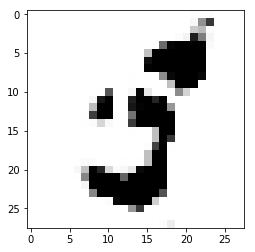

Estimate: [[-71.55526]]
Iteration: 8800 at 2019-05-29 14:12:34.226280


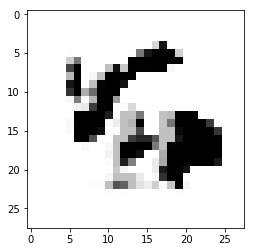

Estimate: [[-18.737698]]
Iteration: 8900 at 2019-05-29 14:13:11.782523


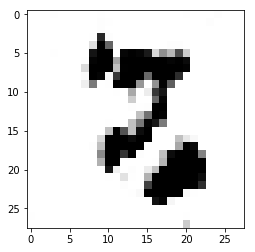

Estimate: [[-1.5207253]]
Iteration: 9000 at 2019-05-29 14:13:49.464766


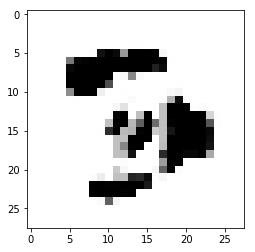

Estimate: [[-40.87378]]
Iteration: 9100 at 2019-05-29 14:14:27.412321


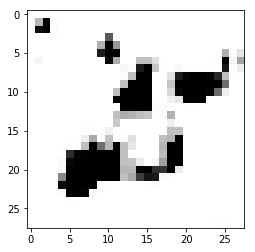

Estimate: [[-32.454662]]
Iteration: 9200 at 2019-05-29 14:15:05.520218


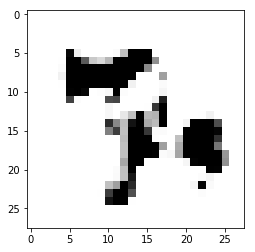

Estimate: [[-1.3671169]]
Iteration: 9300 at 2019-05-29 14:15:43.085450


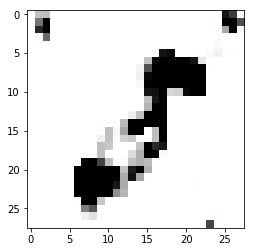

Estimate: [[49.537136]]
Iteration: 9400 at 2019-05-29 14:16:21.104275


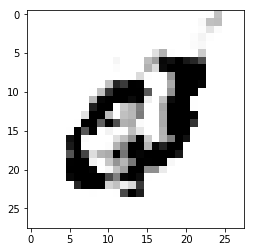

Estimate: [[-8.460402]]
Iteration: 9500 at 2019-05-29 14:16:59.819951


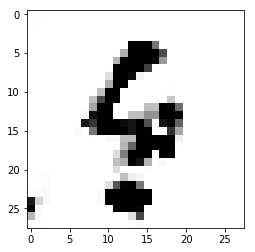

Estimate: [[-13.340718]]
Iteration: 9600 at 2019-05-29 14:17:38.099894


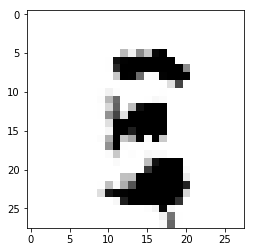

Estimate: [[-62.3195]]
Iteration: 9700 at 2019-05-29 14:18:15.033530


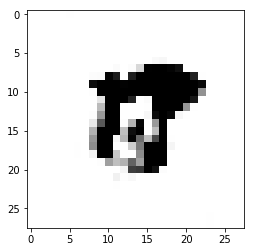

Estimate: [[-60.41309]]
Iteration: 9800 at 2019-05-29 14:18:52.250358


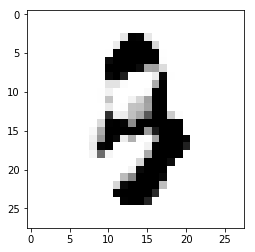

Estimate: [[-20.580591]]
Iteration: 9900 at 2019-05-29 14:19:29.261430


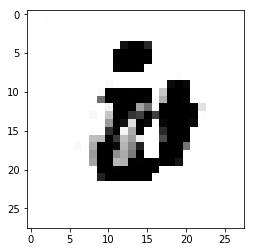

Estimate: [[4.0116167]]
Iteration: 10000 at 2019-05-29 14:20:06.791598


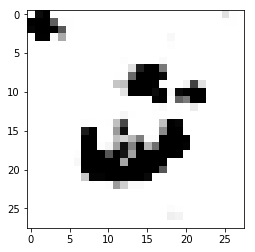

Estimate: [[-50.23428]]
Iteration: 10100 at 2019-05-29 14:20:44.604915


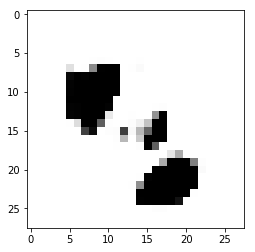

Estimate: [[44.020462]]
Iteration: 10200 at 2019-05-29 14:21:22.646046


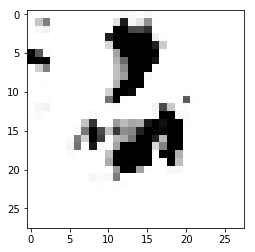

Estimate: [[42.60036]]
Iteration: 10300 at 2019-05-29 14:22:02.714107


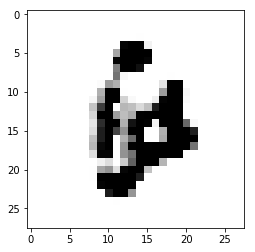

Estimate: [[-38.651302]]
Iteration: 10400 at 2019-05-29 14:22:41.239934


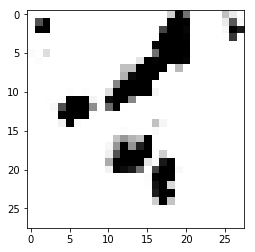

Estimate: [[17.831017]]
Iteration: 10500 at 2019-05-29 14:23:19.803490


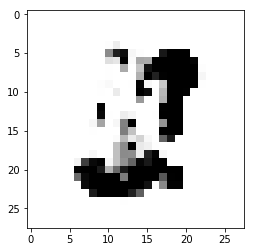

Estimate: [[-72.22756]]
Iteration: 10600 at 2019-05-29 14:23:58.359159


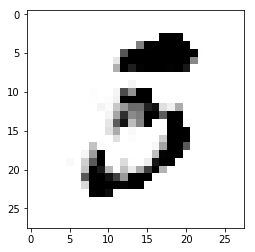

Estimate: [[17.19963]]
Iteration: 10700 at 2019-05-29 14:24:37.135990


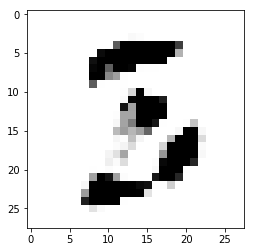

Estimate: [[-21.660215]]
Iteration: 10800 at 2019-05-29 14:25:15.902360


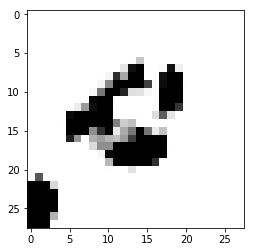

Estimate: [[-30.573803]]
Iteration: 10900 at 2019-05-29 14:25:54.482041


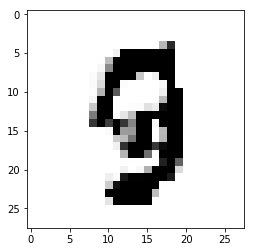

Estimate: [[-23.321613]]
Iteration: 11000 at 2019-05-29 14:26:33.011508


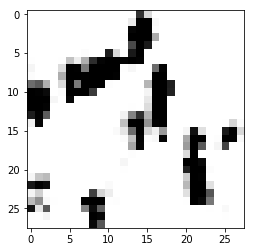

Estimate: [[-106.37981]]
Iteration: 11100 at 2019-05-29 14:27:11.787258


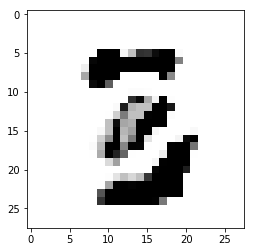

Estimate: [[-70.84529]]
Iteration: 11200 at 2019-05-29 14:27:50.767502


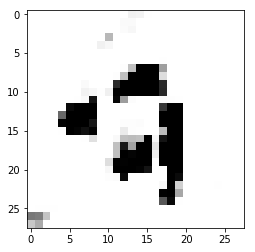

Estimate: [[-52.229084]]
Iteration: 11300 at 2019-05-29 14:28:29.793929


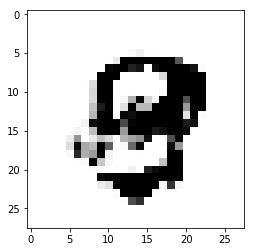

Estimate: [[-81.22648]]
Iteration: 11400 at 2019-05-29 14:29:08.585565


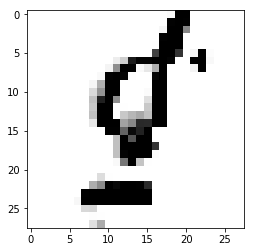

Estimate: [[18.087091]]
Iteration: 11500 at 2019-05-29 14:29:47.672283


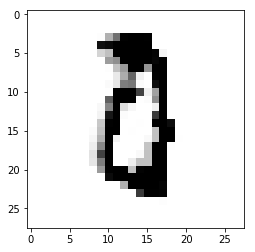

Estimate: [[-55.843243]]
Iteration: 11600 at 2019-05-29 14:30:26.975070


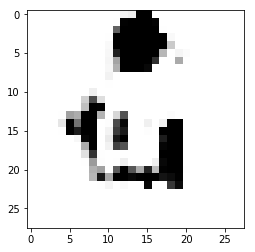

Estimate: [[16.684769]]
Iteration: 11700 at 2019-05-29 14:31:06.012198


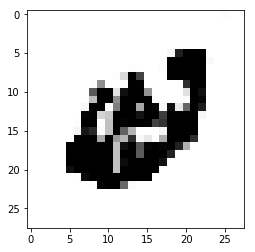

Estimate: [[-23.932697]]
Iteration: 11800 at 2019-05-29 14:31:45.175400


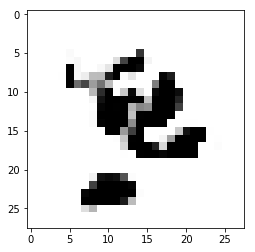

Estimate: [[-55.60468]]
Iteration: 11900 at 2019-05-29 15:12:15.728833


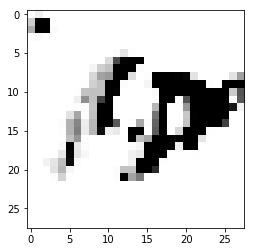

Estimate: [[-98.0035]]
Iteration: 12000 at 2019-05-29 15:40:15.563035


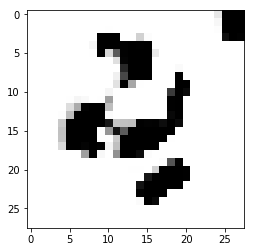

Estimate: [[-30.28238]]
Iteration: 12100 at 2019-05-29 15:40:53.961516


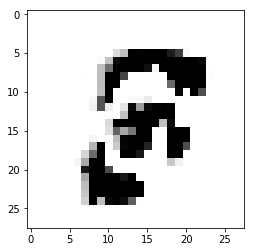

Estimate: [[-45.127174]]
Iteration: 12200 at 2019-05-29 15:41:32.806114


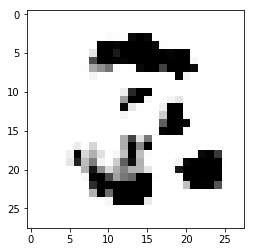

Estimate: [[-181.08487]]
Iteration: 12300 at 2019-05-29 15:42:12.375536


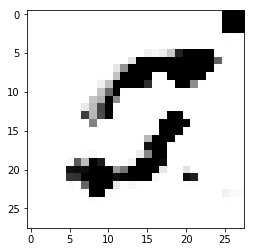

Estimate: [[-18.576042]]
Iteration: 12400 at 2019-05-29 15:42:53.466160


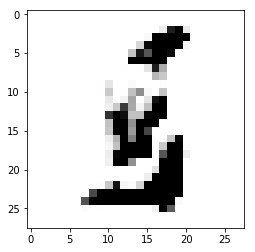

Estimate: [[-109.16965]]
Iteration: 12500 at 2019-05-29 15:43:34.129312


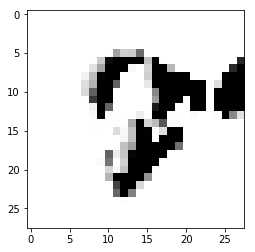

Estimate: [[-140.63164]]
Iteration: 12600 at 2019-05-29 15:44:15.920931


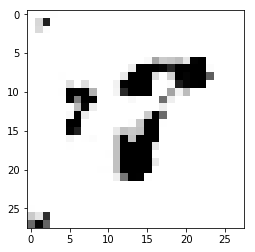

Estimate: [[-50.926075]]
Iteration: 12700 at 2019-05-29 15:44:56.279201


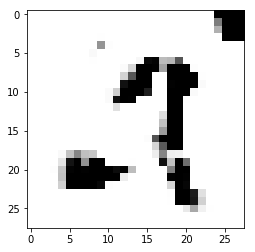

Estimate: [[6.0532317]]
Iteration: 12800 at 2019-05-29 15:45:36.579357


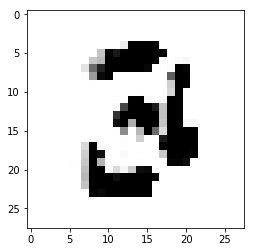

Estimate: [[-29.061567]]
Iteration: 12900 at 2019-05-29 15:46:17.711337


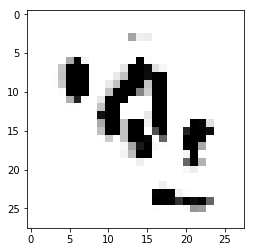

Estimate: [[-135.55956]]
Iteration: 13000 at 2019-05-29 15:46:58.387068


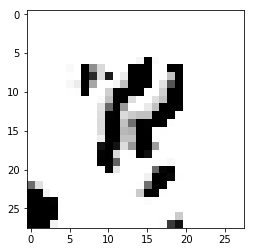

Estimate: [[-64.56694]]
Iteration: 13100 at 2019-05-29 15:47:40.055652


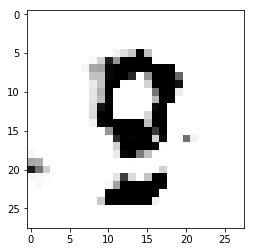

Estimate: [[-128.53035]]
Iteration: 13200 at 2019-05-29 15:48:21.340020


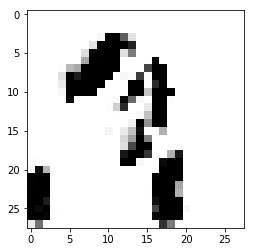

Estimate: [[-48.54891]]
Iteration: 13300 at 2019-05-29 15:49:02.851890


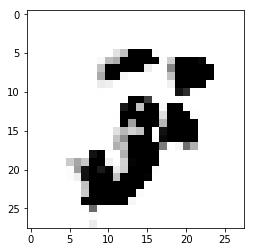

Estimate: [[-66.81916]]
Iteration: 13400 at 2019-05-29 15:49:43.910685


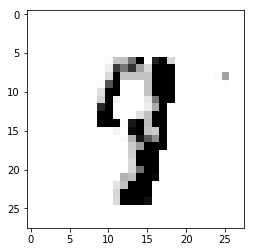

Estimate: [[-29.737896]]
Iteration: 13500 at 2019-05-29 15:50:23.713484


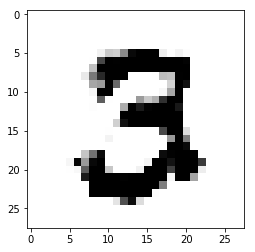

Estimate: [[12.245909]]
Iteration: 13600 at 2019-05-29 15:51:04.874965


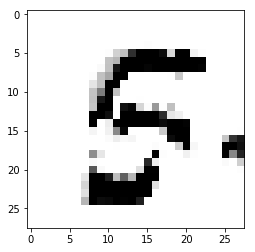

Estimate: [[-72.28023]]
Iteration: 13700 at 2019-05-29 15:51:46.188491


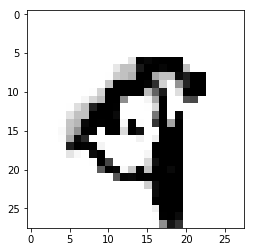

Estimate: [[-12.342777]]
Iteration: 13800 at 2019-05-29 15:52:28.309829


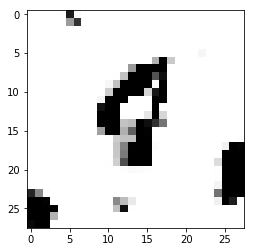

Estimate: [[-53.986443]]
Iteration: 13900 at 2019-05-29 15:53:10.267694


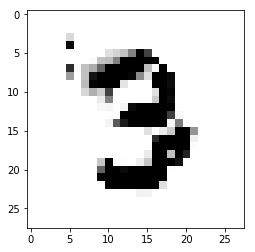

Estimate: [[-35.559704]]
Iteration: 14000 at 2019-05-29 15:53:52.104193


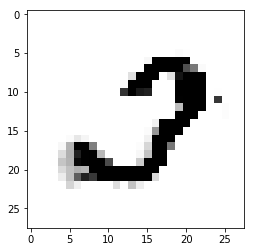

Estimate: [[1.4384449]]
Iteration: 14100 at 2019-05-29 15:54:32.372777


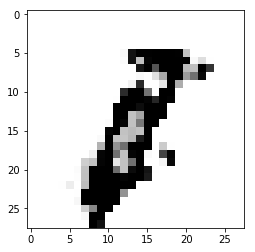

Estimate: [[-12.472851]]
Iteration: 14200 at 2019-05-29 15:55:12.590610


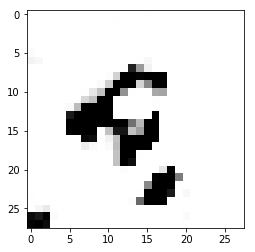

Estimate: [[-50.097412]]
Iteration: 14300 at 2019-05-29 15:55:52.494607


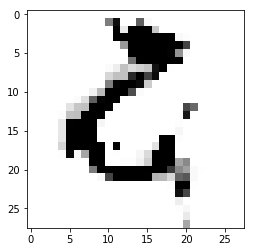

Estimate: [[-19.598848]]
Iteration: 14400 at 2019-05-29 15:56:32.823881


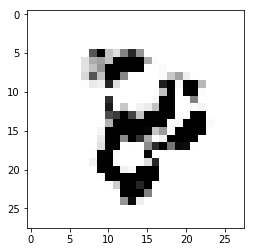

Estimate: [[-67.460365]]
Iteration: 14500 at 2019-05-29 15:57:14.597956


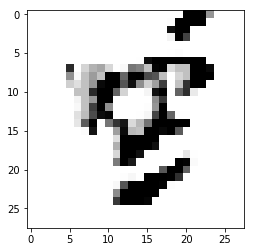

Estimate: [[12.765692]]
Iteration: 14600 at 2019-05-29 15:57:56.340562


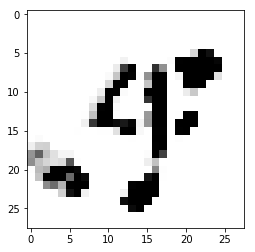

Estimate: [[-55.66126]]
Iteration: 14700 at 2019-05-29 15:58:37.875864


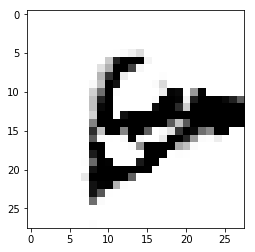

Estimate: [[37.123947]]
Iteration: 14800 at 2019-05-29 15:59:18.645029


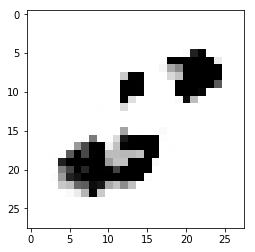

Estimate: [[-184.34947]]
Iteration: 14900 at 2019-05-29 15:59:59.021879


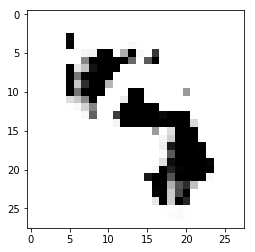

Estimate: [[-16.562744]]
Iteration: 15000 at 2019-05-29 16:00:38.538790


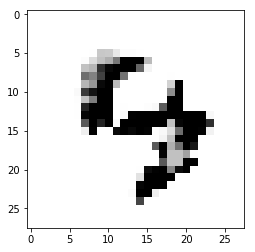

Estimate: [[-68.91723]]
Iteration: 15100 at 2019-05-29 16:01:18.226198


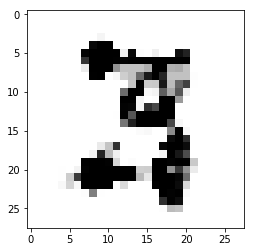

Estimate: [[-35.448826]]
Iteration: 15200 at 2019-05-29 16:01:57.601895


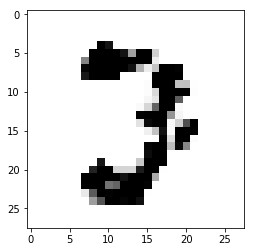

Estimate: [[-15.866578]]
Iteration: 15300 at 2019-05-29 16:02:36.893216


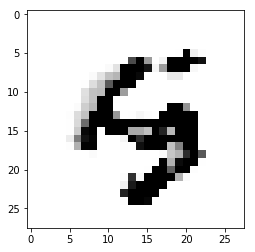

Estimate: [[-24.10183]]
Iteration: 15400 at 2019-05-29 16:03:16.126993


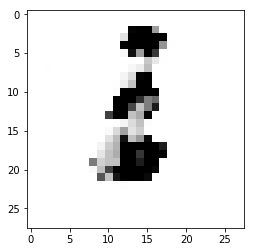

Estimate: [[-23.012062]]
Iteration: 15500 at 2019-05-29 16:03:55.423280


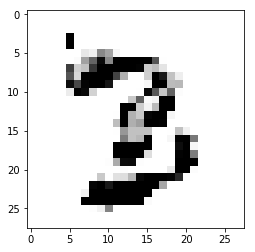

Estimate: [[0.04318654]]
Iteration: 15600 at 2019-05-29 16:04:34.850991


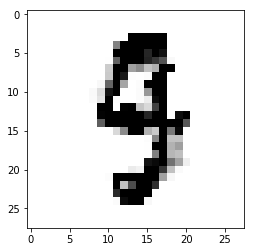

Estimate: [[-18.206224]]
Iteration: 15700 at 2019-05-29 16:05:14.373788


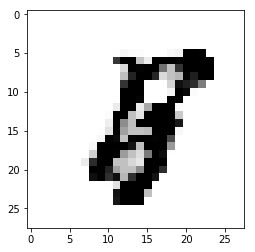

Estimate: [[5.655528]]
Iteration: 15800 at 2019-05-29 16:05:54.007842


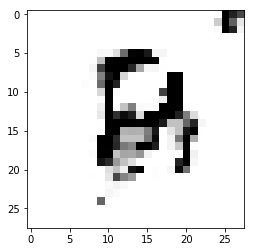

Estimate: [[-62.294697]]
Iteration: 15900 at 2019-05-29 16:06:35.292157


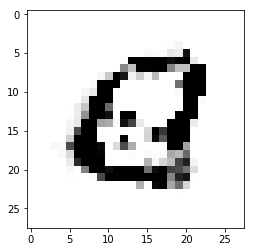

Estimate: [[-44.833755]]
Iteration: 16000 at 2019-05-29 16:07:16.530379


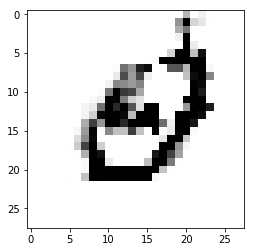

Estimate: [[-26.43639]]
Iteration: 16100 at 2019-05-29 16:07:57.900143


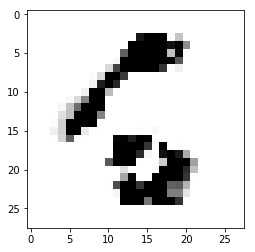

Estimate: [[-51.73386]]
Iteration: 16200 at 2019-05-29 16:08:40.342783


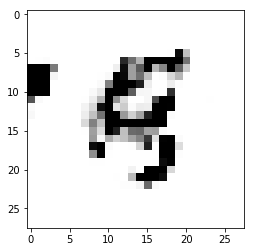

Estimate: [[2.1741662]]
Iteration: 16300 at 2019-05-29 16:09:19.350296


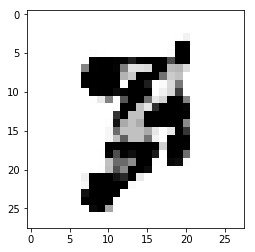

Estimate: [[-27.662283]]
Iteration: 16400 at 2019-05-29 16:09:59.427000


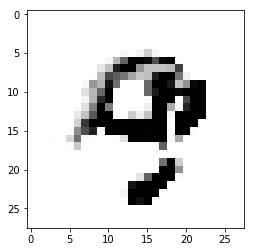

Estimate: [[30.06859]]
Iteration: 16500 at 2019-05-29 16:10:39.939916


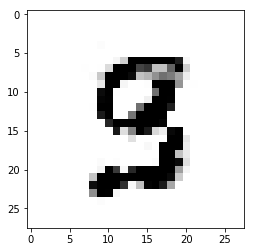

Estimate: [[-28.509838]]
Iteration: 16600 at 2019-05-29 16:11:19.916368


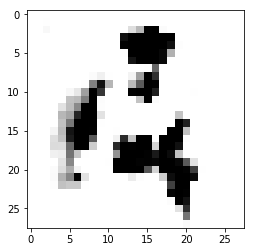

Estimate: [[-10.117291]]
Iteration: 16700 at 2019-05-29 16:12:00.543460


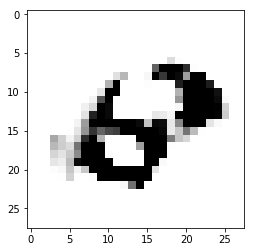

Estimate: [[-65.172295]]
Iteration: 16800 at 2019-05-29 16:12:42.465004


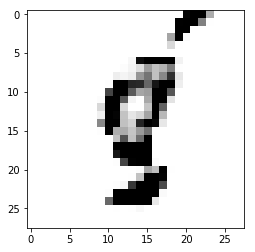

Estimate: [[19.381561]]
Iteration: 16900 at 2019-05-29 16:13:22.494376


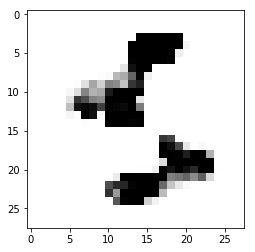

Estimate: [[-7.929669]]
Iteration: 17000 at 2019-05-29 16:14:02.367698


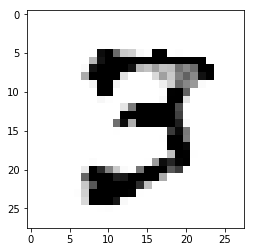

Estimate: [[-54.23724]]
Iteration: 17100 at 2019-05-29 16:14:42.370151


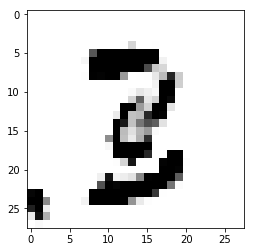

Estimate: [[-45.091724]]
Iteration: 17200 at 2019-05-29 16:15:23.736240


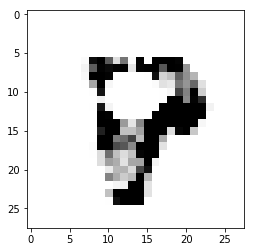

Estimate: [[-40.405277]]
Iteration: 17300 at 2019-05-29 16:16:04.576583


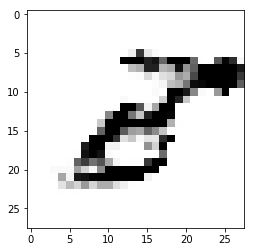

Estimate: [[-60.004063]]
Iteration: 17400 at 2019-05-29 16:16:45.416672


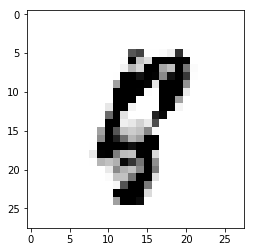

Estimate: [[-50.177135]]
Iteration: 17500 at 2019-05-29 16:17:25.981906


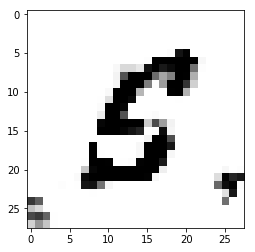

Estimate: [[-53.963215]]
Iteration: 17600 at 2019-05-29 16:18:06.577260


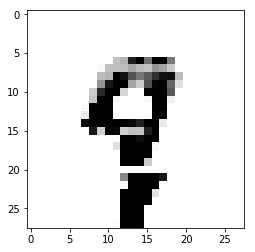

Estimate: [[-34.347107]]
Iteration: 17700 at 2019-05-29 16:18:47.183721


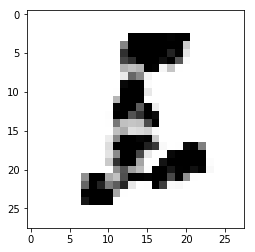

Estimate: [[-19.351715]]
Iteration: 17800 at 2019-05-29 16:19:27.598971


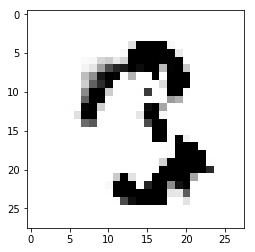

Estimate: [[-93.736694]]
Iteration: 17900 at 2019-05-29 16:20:08.729795


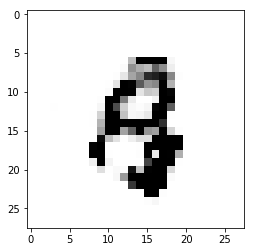

Estimate: [[-50.399384]]
Iteration: 18000 at 2019-05-29 16:20:48.204758


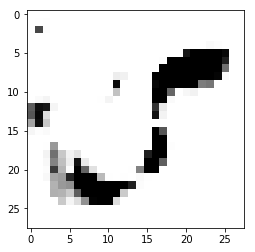

Estimate: [[-35.96344]]
Iteration: 18100 at 2019-05-29 16:21:29.264704


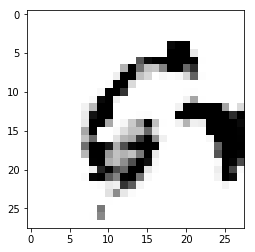

Estimate: [[-154.94653]]
Iteration: 18200 at 2019-05-29 16:22:09.501362


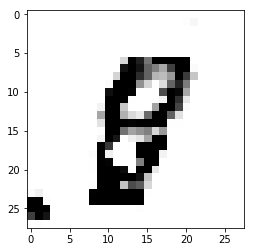

Estimate: [[-31.45466]]
Iteration: 18300 at 2019-05-29 16:22:49.241396


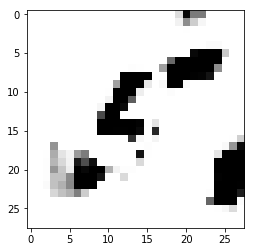

Estimate: [[-2.5624352]]
Iteration: 18400 at 2019-05-29 16:23:29.427200


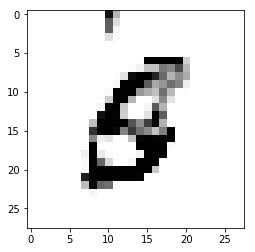

Estimate: [[-40.817867]]
Iteration: 18500 at 2019-05-29 16:24:09.731123


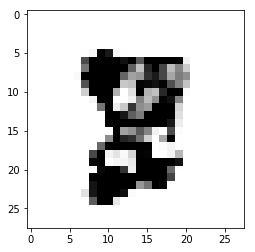

Estimate: [[-8.718827]]
Iteration: 18600 at 2019-05-29 16:24:50.118376


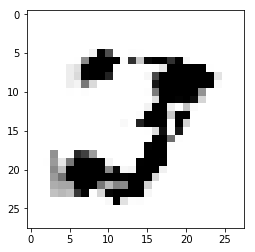

Estimate: [[-60.291096]]
Iteration: 18700 at 2019-05-29 16:25:30.491824


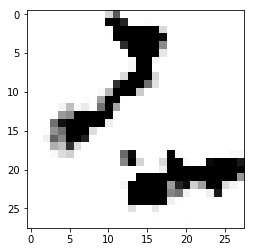

Estimate: [[-7.319848]]
Iteration: 18800 at 2019-05-29 16:26:11.032338


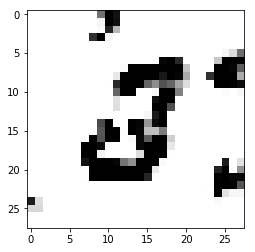

Estimate: [[-68.57796]]
Iteration: 18900 at 2019-05-29 16:26:53.850890


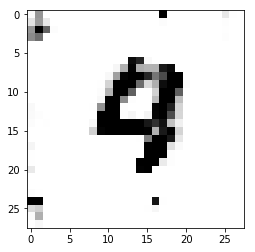

Estimate: [[-116.7852]]
Iteration: 19000 at 2019-05-29 16:27:32.874337


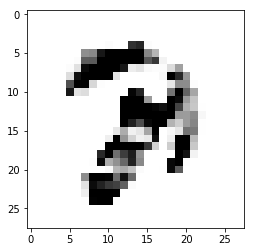

Estimate: [[-41.99649]]
Iteration: 19100 at 2019-05-29 16:28:12.007111


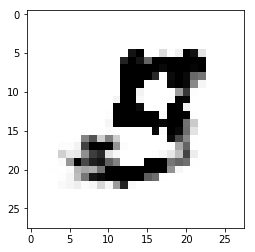

Estimate: [[-35.421574]]
Iteration: 19200 at 2019-05-29 16:28:52.181486


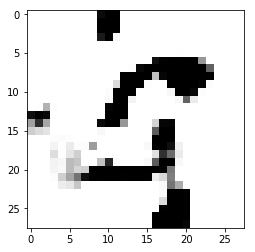

Estimate: [[-49.8794]]
Iteration: 19300 at 2019-05-29 16:29:32.195206


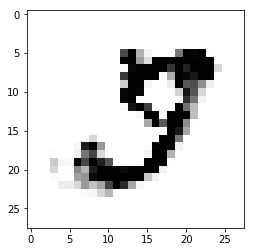

Estimate: [[-53.009262]]
Iteration: 19400 at 2019-05-29 16:30:12.493660


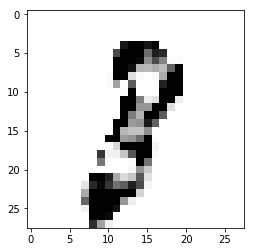

Estimate: [[-38.68517]]
Iteration: 19500 at 2019-05-29 16:30:52.749483


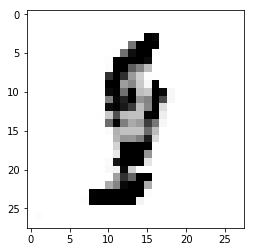

Estimate: [[-69.77442]]
Iteration: 19600 at 2019-05-29 16:31:32.530572


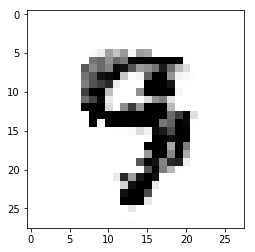

Estimate: [[-65.40863]]
Iteration: 19700 at 2019-05-29 16:32:12.513412


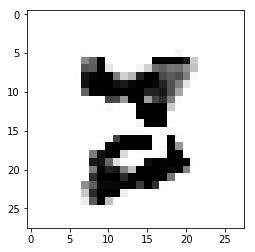

Estimate: [[-41.576496]]
Iteration: 19800 at 2019-05-29 16:32:52.574340


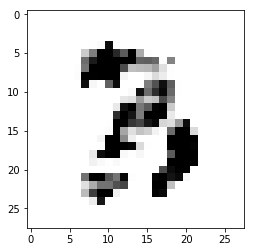

Estimate: [[-50.001415]]
Iteration: 19900 at 2019-05-29 16:33:32.632409


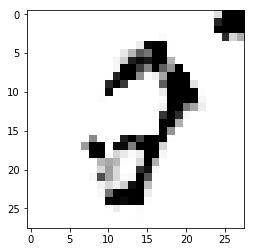

Estimate: [[-71.52377]]
Iteration: 20000 at 2019-05-29 16:34:12.803627


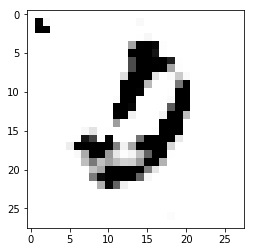

Estimate: [[-38.91887]]
Iteration: 20100 at 2019-05-29 16:34:52.876264


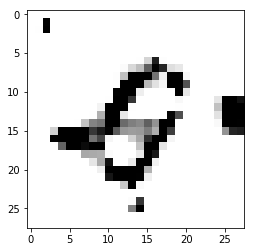

Estimate: [[-35.305122]]
Iteration: 20200 at 2019-05-29 16:35:33.229659


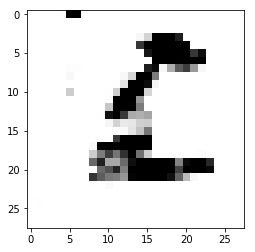

Estimate: [[-60.5171]]
Iteration: 20300 at 2019-05-29 16:36:13.534068


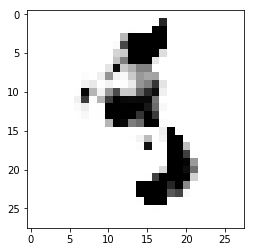

Estimate: [[-58.532154]]
Iteration: 20400 at 2019-05-29 16:36:52.285852


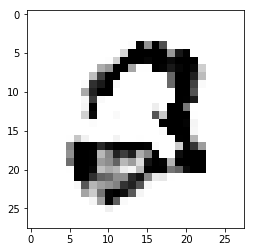

Estimate: [[-50.37458]]
Iteration: 20500 at 2019-05-29 16:37:32.554851


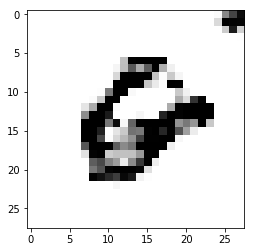

Estimate: [[-44.2632]]
Iteration: 20600 at 2019-05-29 16:38:18.468299


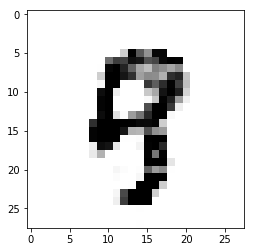

Estimate: [[-19.08717]]


KeyboardInterrupt: 

In [14]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Pre-train discriminator
for i in range(300):
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    if(i % 100 == 0):
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

# Train generator and discriminator together
for i in range(100000):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

    # Train discriminator on both real and fake images
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    # Train generator
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})

    if i % 10 == 0:
        # Update TensorBoard with summary statistics
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        summary = sess.run(merged, {z_placeholder: z_batch, x_placeholder: real_image_batch})
        writer.add_summary(summary, i)

    if i % 100 == 0:
        # Every 100 iterations, show a generated image
        print("Iteration:", i, "at", datetime.datetime.now())
        z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
        generated_images = generator(z_placeholder, 1, z_dimensions)
        images = sess.run(generated_images, {z_placeholder: z_batch})
        plt.imshow(images[0].reshape([28, 28]), cmap='Greys')
        plt.show()

        # Show discriminator's estimate
        im = images[0].reshape([1, 28, 28, 1])
        result = discriminator(x_placeholder)
        estimate = sess.run(result, {x_placeholder: im})
        print("Estimate:", estimate)

Because it can take so long to train a GAN, we recommend that you skip the cell above and execute the following cell. It loads a model that we've already trained for several hours on a fast GPU machine, and lets you experiment with the output of a trained GAN.

In [ ]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, 'pretrained-model/pretrained_gan.ckpt')
    z_batch = np.random.normal(0, 1, size=[10, z_dimensions])
    z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
    generated_images = generator(z_placeholder, 10, z_dimensions)
    images = sess.run(generated_images, {z_placeholder: z_batch})
    for i in range(10):
        plt.imshow(images[i].reshape([28, 28]), cmap='Greys')
        plt.show()

## Training difficulties

GANs are notoriously difficult to train. Without the right hyperparameters, network architecture, and training procedure, the discriminator can overpower the generator, or vice-versa.

In one common failure mode, the discriminator overpowers the generator, classifying generated images as fake with absolute certainty. When the discriminator responds with absolute certainty, it leaves no gradient for the generator to descend. This is partly why we built our discriminator to produce unscaled output rather than passing its output through a sigmoid function that would push its evaluation toward either 0 or 1.

In another common failure mode known as **mode collapse**, the generator discovers and exploits some weakness in the discriminator. You can recognize mode collapse in your GAN if it generates many very similar images regardless of variation in the generator input _z_. Mode collapse can sometimes be corrected by "strengthening" the discriminator in some way—for instance, by adjusting its training rate or by reconfiguring its layers.

Researchers have identified a handful of ["GAN hacks"](https://github.com/soumith/ganhacks) that can be helpful in building stable GANs.

## Closing thoughts

GANs have tremendous potential to reshape the digital world that we interact with every day. The field is still very young, and the next great GAN discovery could be yours!

## Other resources

- [The original GAN paper](https://arxiv.org/abs/1406.2661) by Ian Goodfellow and his collaborators, published in 2014
- [A more recent tutorial by Goodfellow](https://arxiv.org/abs/1701.00160) that explains GANs in somewhat more accessible terms
- [A paper by Alec Radford, Luke Metz, and Soumith Chintala](https://arxiv.org/abs/1511.06434) that introduces deep convolutional GANs, whose basic structure we use in our generator in this tutorial. Also see [their DCGAN code on GitHub](https://github.com/Newmu/dcgan_code).
- [A reference collection of generative networks by Agustinus Kristiadi](https://github.com/wiseodd/generative-models), implemented in TensorFlow